In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [237]:
class Cell:
    def __init__(self, log_length0, gfp0, lambda0, q0, cell_id = '0', parent_id='-1'):
        self.parent_id = parent_id
        self.cell_id = cell_id
        self.length = [np.exp(log_length0)]  # s(t)
        self.log_length = [log_length0]      # x(t) = x0 + int lambda dt
        self.gfp = [gfp0]
        self.time = [0.]
        self.qt = [q0]
        self.lambda_t = [lambda0]

    def to_df(self, n=1):
        ids = [self.cell_id]*len(self.time)
        p_ids = [self.parent_id]*len(self.time)
        return pd.DataFrame({   "cell_id": ids[::n],
                                "time": self.time[::n],
                                "parent_id": p_ids[::n],
                                "log_length": self.log_length[::n], 
                                "gfp": self.gfp[::n]})


In [238]:
def OU_step(dt, mean, gamma, var, x):
    noise = np.sqrt(var) * np.random.normal(loc=0,scale=1) * np.sqrt(dt)
    drift = -gamma * (x-mean)
    return drift*dt + noise

def growth(cell, dt, mean_lambda, gamma_lambda, var_lambda):  
    # calculate next step
    lambda_t = OU_step(dt, mean_lambda, gamma_lambda, var_lambda, cell.lambda_t[-1])
    next_step = cell.log_length[-1] + lambda_t

    # save everything
    cell.lambda_t.append(lambda_t)
    cell.log_length.append(next_step)
    cell.length.append(np.exp(next_step))
    cell.time.append(cell.time[-1]+dt)
    return cell


def gfp_production(cell, dt, mean_q, gamma_q, var_q, beta):
    # calculate next step
    qt = OU_step(dt, mean_q, gamma_q, var_q, cell.qt[-1])
    next_step = cell.gfp[-1] + cell.length[-1]*qt - cell.gfp[-1]*beta*dt   

    cell.qt.append(qt)
    cell.gfp.append(next_step)
    return cell

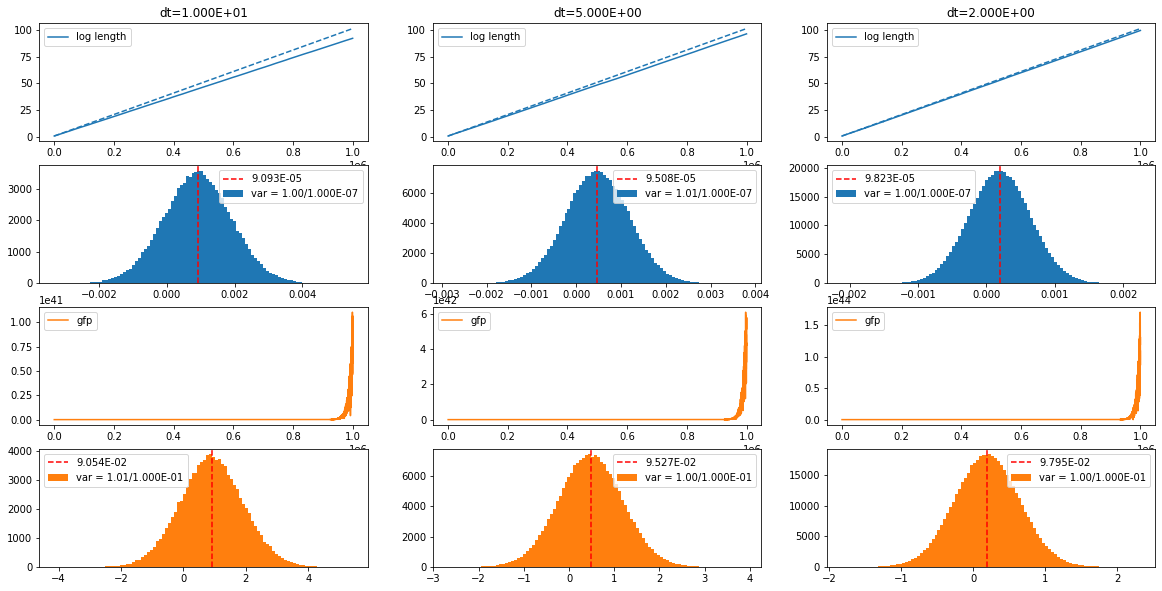

In [239]:

mean_lambda = 0.01
gamma_lambda = 0.01
var_lambda = 1e-7
mean_q = 10
gamma_q = 1e-2
var_q = 0.1
# beta = 0.01

dt_list = [10, 5, 2]
fig, ax = plt.subplots(4,len(dt_list), figsize=(20,10))
for i, dt in enumerate(dt_list):
    cell = Cell(1, 1, mean_lambda*0.1, mean_q*0.1)
    for t in range( int(1000000/dt) ):
        cell = gfp_production(cell, dt, mean_q, gamma_q, var_q, beta)
        cell = growth(cell, dt, mean_lambda, gamma_lambda, var_lambda)


    ax[0,i].set_title("dt={:.3E}".format(dt))
    ax[0,i].plot(cell.time, np.array(cell.log_length), label='log length')
    ax[0,i].plot(cell.time, cell.log_length[0] + gamma_lambda*mean_lambda*np.array(cell.time), ls='--', color='tab:blue')

    ax[1,i].hist(np.array(cell.lambda_t), bins=100, label = "var = {:.2f}/{:.3E}".format(np.var(cell.lambda_t)/dt/var_lambda, var_lambda))
    ax[1,i].axvline(np.mean(cell.lambda_t), ls='--', color='red', label = "{:.3E}".format(np.mean(cell.lambda_t)/dt))
  
    ax[2,i].plot(cell.time, np.array(cell.gfp), color='tab:orange', label='gfp')

    ax[3,i].hist(np.array(cell.qt), bins=100, color='tab:orange', label = "var = {:.2f}/{:.3E}".format(np.var(cell.qt)/dt/var_q, var_q))
    ax[3,i].axvline(np.mean(cell.qt), ls='--', color='red', label = "{:.3E}".format(np.mean(cell.qt)/dt))
    
    ax[0,i].legend()
    ax[1,i].legend()
    ax[2,i].legend()
    ax[3,i].legend()

plt.show()


['3', '3']

In [240]:
var_x = 1e-3
var_g = 5e3

cell_df = cell.to_df(n=100)
cell_df["log_length_noise"] = cell_df["log_length"] + np.random.normal(loc=np.zeros_like(cell_df["log_length"]), scale=np.sqrt(var_x))
cell_df["gfp_noise"] = cell_df["gfp"] + np.random.normal(loc=np.zeros_like(cell_df["gfp"]), scale=np.sqrt(var_g))
cell_df.head()

,cell_id,time,parent_id,log_length,gfp,log_length_noise,gfp_noise
0,0,0.0,-1,1.000000,1.000000,0.987193,-24.481741
1,0,200.0,-1,1.020889,24.831853,1.042125,-53.270089
2,0,400.0,-1,1.038514,20.990054,1.082565,3.052988
3,0,600.0,-1,1.059757,24.071807,1.058742,72.676303
4,0,800.0,-1,1.080785,34.358024,1.055739,-26.867060


In [236]:
out_dir = '../data/new_sim/'
! mkdir $out_dir
cell_df.to_csv(out_dir+'new_sim.csv')